# Reconhecimento de Personagens de Two and a Half Men usando YOLOv8 e Reconhecimento de objetos usando a WebCam

## Introdução
Este notebook demonstra a implementação de um sistema de detecção de objetos usando YOLOv8, focando nos personagens principais da série "Two and a Half Men". O projeto inclui três componentes principais:
1. Treinamento personalizado da YOLOv8 para reconhecimento dos personagens Charlie, Alan e Jake
2. Detecção de objetos usando webcam com modelo COCO pré-treinado
3. Reconhecimento em tempo real via webcam

## Configuração do Ambiente
Este notebook requer algumas dependências principais que serão instaladas a seguir.

In [1]:
# Dependências Principais
!pip install --upgrade pip
!pip install ultralytics opencv-python-headless numpy matplotlib tqdm kaggle pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.4/911.4 kB 7.4 MB/s eta 0:00:00


In [9]:
# Imports Globais
import os
import shutil
import io
import time
import base64
from base64 import b64decode, b64encode
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from ultralytics import YOLO
from IPython.display import display, HTML, Image, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow

### Configuração do Dataset ###


In [3]:
# Instalação da API do Kaggle
!pip install kaggle

# Baixar o dataset diretamente do Kaggle (público)
!kaggle datasets download -d rafaelbortoluzzi/two-and-a-half-men

# Extrair o dataset
!unzip -q two-and-a-half-men.zip -d ./dataset

# Conferir estrutura do diretório extraído
!ls ./dataset

Dataset URL: https://www.kaggle.com/datasets/rafaelbortoluzzi/two-and-a-half-men
License(s): MIT
 99% 289M/291M [00:02<00:00, 162MB/s]
100% 291M/291M [00:02<00:00, 139MB/s]
Alan  Charlie  Jake  Samples


## Preparação do Dataset para Treinamento YOLOv8

### Objetivo
Esta seção é responsável pela organização e estruturação do dataset para treinamento do modelo YOLOv8. O código reorganiza as imagens e suas respectivas anotações (labels) em uma estrutura padronizada exigida pelo YOLOv8.

### Estrutura do Dataset
- **Classes**: Alan, Charlie e Jake (personagens principais de Two and a Half Men)
- **Divisão**: Separação entre conjuntos de treino e validação
- **Formato**:
  - Imagens: formato JPG
  - Labels: formato YOLO (txt)

### Processo de Organização
1. **Criação de Diretórios**:
   - train/images: Imagens para treinamento
   - train/labels: Anotações para treinamento
   - val/images: Imagens para validação
   - val/labels: Anotações para validação

2. **Consolidação de Dados**:
   - Move todas as imagens e labels de cada classe para os diretórios correspondentes
   - Mantém a correspondência entre imagens e suas anotações
   - Preserva a divisão entre dados de treino e validação

3. **Configuração YAML**:
   - Cria arquivo data.yaml necessário para o treinamento
   - Define caminhos para conjuntos de treino e validação
   - Especifica número e nomes das classes

### Estrutura Final
```
dataset/
├── train/
│ ├── images/
│ └── labels/
├── val/
│ ├── images/
│ └── labels/
└── data.yaml
```


In [4]:
# Diretório base do dataset
dataset_dir = "/content/dataset"

# Subpastas das classes
classes = ["Alan", "Charlie", "Jake"]

# Diretórios consolidados para treino e validação
train_images_dir = f"{dataset_dir}/train/images"
train_labels_dir = f"{dataset_dir}/train/labels"
val_images_dir = f"{dataset_dir}/val/images"
val_labels_dir = f"{dataset_dir}/val/labels"

# Cria os diretórios, se não existirem
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Consolidar imagens e labels de todas as classes
for cls in classes:
    # Diretórios de treino e validação da classe
    train_dir = os.path.join(dataset_dir, cls, "train")
    val_dir = os.path.join(dataset_dir, cls, "val")

    # Mover imagens e labels de treino
    if os.path.exists(train_dir):
        for file_name in os.listdir(os.path.join(train_dir, "images")):
            shutil.move(
                os.path.join(train_dir, "images", file_name),
                os.path.join(train_images_dir, file_name)
            )
        for file_name in os.listdir(os.path.join(train_dir, "labels")):
            shutil.move(
                os.path.join(train_dir, "labels", file_name),
                os.path.join(train_labels_dir, file_name)
            )

    # Mover imagens e labels de validação
    if os.path.exists(val_dir):
        for file_name in os.listdir(os.path.join(val_dir, "images")):
            shutil.move(
                os.path.join(val_dir, "images", file_name),
                os.path.join(val_images_dir, file_name)
            )
        for file_name in os.listdir(os.path.join(val_dir, "labels")):
            shutil.move(
                os.path.join(val_dir, "labels", file_name),
                os.path.join(val_labels_dir, file_name)
            )

print("Dados consolidados com sucesso!")

# Criar o arquivo data.yaml
data_yaml = f"""
train: {train_images_dir}
val: {val_images_dir}

nc: {len(classes)}  # Número de classes
names: {list(map(str.lower, classes))}
"""

yaml_path = os.path.join(dataset_dir, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print(f"Arquivo data.yaml criado em: {yaml_path}")


Dados consolidados com sucesso!
Arquivo data.yaml criado em: /content/dataset/data.yaml


## Treinamento do Modelo YOLOv8 para Detecção de Personagens

### Configuração do Modelo
Este projeto utiliza a YOLOv8 (You Only Look Once versão 8) para detecção dos personagens de Two and a Half Men. Após diversos testes, identificamos as seguintes configurações ideais:

### Escolha do Modelo
- **Modelo Recomendado**: YOLOv8l (Large)
- **Razão**: Dataset construído via WebScraping necessita de uma rede mais robusta para melhor generalização
- **Alternativas**:
  - YOLOv8m (Medium): Opção alternativa com bom equilíbrio entre performance e recursos
  - Não recomendado: Modelos menores (Nano, Small) podem não capturar características suficientes

### Parâmetros de Treinamento
```python
model.train(
    data="/content/dataset/data.yaml",  # Arquivo de configuração do dataset
    epochs=100,                         # Número de épocas de treinamento
    imgsz=640,                         # Tamanho das imagens de entrada
    batch=16                           # Tamanho do batch
)

In [13]:
# Baixe o modelo YOLOv8 pré-treinado
model = YOLO('yolov8l.pt')  # Use 'yolov8n.pt' (Nano) ou outros modelos como 'yolov8s.pt'


100%|██████████| 83.7M/83.7M [00:00<00:00, 284MB/s]


In [14]:
# Treine o modelo
model.train(data="/content/dataset/data.yaml", epochs=100, imgsz=640, batch=16)


Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.3MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 491 images, 0 backgrounds, 4 corrupt: 100%|██████████| 491/491 [00:00<00:00, 1472.67it/s]

train: WARNING ⚠️ /content/dataset/train/images/charlie20_aug_8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0741]
train: WARNING ⚠️ /content/dataset/train/images/charlie7_aug_8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0731]
train: WARNING ⚠️ /content/dataset/train/images/jake16_aug_8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0597]
train: WARNING ⚠️ /content/dataset/train/images/jake19_aug_8.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.083]
train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 1300.00it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.4G      1.405      3.325      1.777         23        640: 100%|██████████| 31/31 [00:07<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        123        144    0.00918      0.373     0.0123    0.00475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      10.4G      1.316      2.061      1.667         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

                   all        123        144   0.000989     0.0749   0.000514   0.000174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      10.5G      1.445      1.958      1.746         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144   0.000498     0.0681   0.000801   0.000269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      10.6G      1.513      1.886      1.768         23        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

                   all        123        144    0.00154      0.383    0.00178   0.000551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      10.4G      1.362      1.712      1.669         26        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

                   all        123        144      0.112      0.173     0.0665     0.0424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      10.5G      1.365      1.606      1.692         24        640: 100%|██████████| 31/31 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

                   all        123        144      0.383     0.0292     0.0388     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      10.5G      1.283      1.524      1.605         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all        123        144      0.119     0.0477     0.0234     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      10.6G      1.246      1.497      1.607         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]

                   all        123        144      0.497      0.576      0.476        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.4G      1.302      1.433      1.641         16        640: 100%|██████████| 31/31 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.348      0.778      0.456      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      10.5G      1.198      1.389      1.546         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]

                   all        123        144      0.513       0.71      0.578      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      10.5G      1.154      1.368      1.538         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        123        144      0.525      0.673       0.56      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      10.6G      1.142      1.298      1.536         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        123        144      0.608      0.609      0.648      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      10.4G      1.127      1.257      1.526         13        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.711      0.741      0.758      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.5G      1.117      1.286      1.511         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144      0.588      0.721      0.618      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      10.5G      1.111      1.187      1.526         28        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        123        144      0.724      0.581      0.656      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      10.6G      1.081      1.151      1.507         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        123        144      0.794      0.696      0.784      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      10.4G      1.115      1.156      1.518         29        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        123        144      0.762      0.772      0.833      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      10.5G      1.096      1.079      1.506         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        123        144      0.788       0.74      0.793      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      10.5G      1.079      1.102      1.496         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all        123        144      0.678      0.638      0.698      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.6G      1.081       1.07      1.481         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        123        144      0.787      0.807      0.824      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.4G       1.05     0.9765      1.463         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

                   all        123        144      0.804       0.88      0.828       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.5G      1.045     0.9945      1.471         15        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        123        144       0.77      0.862      0.838      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.5G     0.9989     0.9445      1.426         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        123        144      0.781      0.855      0.859      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.6G      1.015     0.9315      1.434         23        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        123        144      0.674      0.801      0.817      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.4G     0.9948     0.9161       1.42         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        123        144      0.837      0.887      0.886      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.5G     0.9584     0.8539      1.397         19        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        123        144      0.874      0.776      0.878      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.5G     0.9614     0.8426      1.419         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        123        144      0.892       0.84      0.914      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.6G      0.953     0.8343      1.398         22        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        123        144      0.875      0.794      0.899      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.4G     0.9694     0.8368      1.423         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        123        144      0.828      0.829      0.887      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.5G     0.9791     0.8005      1.438         22        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.918      0.919      0.927      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.5G     0.9357     0.7689      1.394         14        640: 100%|██████████| 31/31 [00:05<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        123        144      0.913      0.875      0.926        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.6G     0.9422     0.7993      1.395         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

                   all        123        144      0.837      0.833      0.867      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.4G      0.932     0.7658      1.401         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144       0.91      0.883       0.93      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.5G     0.9247     0.7587      1.363         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        123        144      0.879      0.856      0.923      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.5G     0.9507     0.7609      1.414         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

                   all        123        144      0.907      0.892      0.926      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.6G     0.8572     0.7127      1.344         25        640: 100%|██████████| 31/31 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        123        144      0.894       0.87      0.917       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.4G     0.9073     0.7109      1.397         17        640: 100%|██████████| 31/31 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.911      0.918      0.939       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.5G     0.9018        0.7      1.385         12        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        123        144      0.879      0.905      0.937      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.5G     0.9017     0.7243      1.364         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        123        144      0.885      0.911      0.926      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.6G     0.8712     0.6981      1.361         26        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        123        144      0.888      0.835      0.917       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.7G     0.8464     0.7045      1.333         14        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        123        144      0.881      0.921      0.937      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.5G     0.8684     0.7112      1.372         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]

                   all        123        144      0.881      0.903       0.93      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.5G     0.8713     0.6929      1.352         13        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        123        144      0.909      0.915      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.6G     0.8913     0.6891      1.405         35        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        123        144      0.895      0.907      0.934      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.4G     0.9143      0.673      1.406         17        640: 100%|██████████| 31/31 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.948      0.918      0.954      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.5G     0.8388     0.6494      1.337         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        123        144      0.946      0.935      0.943      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.5G     0.9278     0.7081      1.401         23        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

                   all        123        144      0.919      0.923      0.935      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.7G     0.8275     0.6787       1.33         14        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        123        144      0.935      0.929      0.951      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.7G     0.8277     0.6616      1.315         18        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144      0.912      0.936      0.949      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.5G     0.8174     0.6427      1.308         15        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        123        144      0.947      0.944       0.94      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.5G     0.8325     0.6676      1.333         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        123        144      0.927      0.952      0.943      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.6G     0.8466     0.6785      1.344         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

                   all        123        144      0.943      0.945      0.946      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.7G     0.8189     0.6225       1.33         19        640: 100%|██████████| 31/31 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        123        144      0.922      0.952      0.947      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.5G     0.8098     0.6335      1.343         13        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all        123        144      0.833      0.923      0.877       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.5G     0.7879     0.6101      1.314         19        640: 100%|██████████| 31/31 [00:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.937      0.935      0.944       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.6G      0.754      0.578      1.285         12        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

                   all        123        144      0.939      0.936      0.942      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.7G     0.7592      0.588      1.292         18        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        123        144      0.935       0.94       0.95      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.5G     0.7578     0.5997      1.279         22        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        123        144      0.922      0.941      0.943      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.5G     0.7753      0.624      1.299         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]

                   all        123        144      0.933      0.929      0.945      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.6G     0.7737     0.5928      1.302         19        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

                   all        123        144      0.925      0.928      0.945       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.4G     0.8063     0.6106      1.328         20        640: 100%|██████████| 31/31 [00:05<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]

                   all        123        144      0.934      0.934      0.952      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.5G     0.7125     0.5316      1.259         13        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144      0.916      0.945      0.956       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.5G     0.7312     0.5628      1.272         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        123        144       0.93      0.922      0.931      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.6G     0.7434     0.5897      1.269         19        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

                   all        123        144      0.928      0.913      0.935      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.4G     0.7152     0.5324       1.25         17        640: 100%|██████████| 31/31 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        123        144      0.949      0.948      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.5G     0.7171     0.5423      1.258         27        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        123        144      0.933      0.935      0.941      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.5G     0.7332     0.5529      1.274         27        640: 100%|██████████| 31/31 [00:05<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]

                   all        123        144      0.917      0.943       0.94      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.6G     0.7125     0.5496      1.252         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        123        144      0.947      0.954      0.962      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.4G     0.6723     0.5311      1.244         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

                   all        123        144      0.924      0.939      0.944      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.5G     0.6837     0.5103       1.24         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        123        144      0.911      0.939       0.95      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.5G     0.7206      0.528      1.275         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]

                   all        123        144      0.919      0.932      0.936      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.6G     0.7068     0.5346      1.251         20        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

                   all        123        144      0.913       0.94      0.945      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.7G     0.6768     0.5567      1.247         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

                   all        123        144      0.905       0.92      0.909      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.5G     0.6887     0.5115       1.25         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        123        144      0.916      0.951      0.947      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.5G     0.7007     0.5461      1.239         18        640: 100%|██████████| 31/31 [00:05<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

                   all        123        144      0.939      0.942      0.944      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.6G     0.6456     0.5056      1.205         15        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

                   all        123        144      0.943      0.952      0.945      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.7G     0.6497     0.4909       1.23         17        640: 100%|██████████| 31/31 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        123        144      0.938      0.944      0.955       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.5G     0.6628      0.513      1.225         11        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        123        144      0.926      0.938      0.947      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.5G      0.653     0.5004      1.221         25        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        123        144      0.934      0.947      0.945      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.6G     0.6317     0.4832      1.192         24        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

                   all        123        144      0.939      0.952       0.95      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      10.4G     0.6557     0.4999      1.238         20        640: 100%|██████████| 31/31 [00:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

                   all        123        144      0.928      0.952      0.946      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      10.5G     0.6583     0.4996      1.244         12        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        123        144      0.944      0.947      0.951      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      10.5G     0.6552     0.5049      1.251         11        640: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        123        144      0.952      0.949      0.953      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      10.6G     0.6105     0.4628       1.19         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

                   all        123        144      0.955       0.96      0.968      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      10.4G     0.6119     0.4553      1.209         21        640: 100%|██████████| 31/31 [00:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

                   all        123        144      0.945      0.927      0.955      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      10.5G     0.6207     0.4714      1.213         21        640: 100%|██████████| 31/31 [00:05<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        123        144      0.939      0.941      0.944      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      10.5G     0.6142     0.4758      1.209         16        640: 100%|██████████| 31/31 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all        123        144      0.937      0.953       0.95       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      10.6G       0.62     0.4451      1.235         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all        123        144      0.939      0.947      0.956      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      10.4G     0.6103     0.4889      1.221         14        640: 100%|██████████| 31/31 [00:05<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        123        144      0.924      0.946      0.945      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      10.5G     0.6287      0.488      1.219         17        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all        123        144      0.945      0.944      0.949      0.786


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      10.5G     0.5692     0.4384      1.214          9        640: 100%|██████████| 31/31 [00:05<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

                   all        123        144      0.951      0.952       0.95      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      10.6G     0.5645     0.4091      1.218         10        640: 100%|██████████| 31/31 [00:05<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.944      0.948       0.95      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.7G     0.5397     0.3888      1.208         10        640: 100%|██████████| 31/31 [00:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

                   all        123        144      0.941      0.953      0.947      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      10.5G      0.533     0.3904      1.201         13        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

                   all        123        144      0.943      0.953      0.951      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      10.5G     0.5396     0.3717      1.191          9        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        123        144      0.943      0.953      0.957      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.6G     0.5282     0.3794      1.199          9        640: 100%|██████████| 31/31 [00:05<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all        123        144      0.942      0.953      0.957      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      10.7G     0.5282      0.375       1.18         11        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

                   all        123        144      0.943      0.953      0.953      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      10.5G      0.524     0.3751      1.194          9        640: 100%|██████████| 31/31 [00:05<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all        123        144      0.943      0.953      0.952      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.5G     0.5168     0.3753      1.202          8        640: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

                   all        123        144      0.942      0.953       0.95      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      10.6G     0.5123      0.374      1.181          8        640: 100%|██████████| 31/31 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

                   all        123        144      0.942      0.953      0.951      0.791



100 epochs completed in 0.208 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


                   all        123        144      0.942      0.953      0.951      0.791
                  alan         38         38      0.896      0.921      0.909      0.712
               charlie         56         57      0.976          1      0.984      0.801
                  jake         41         49      0.955      0.939      0.959      0.858
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cea1c3f17d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Teste do Modelo com Imagens Estáticas

### Objetivo
Esta seção demonstra a capacidade do modelo treinado em detectar os personagens Charlie, Alan e Jake em um conjunto de imagens de teste localizadas na pasta 'Samples'.

### Processo de Detecção
O código realiza as seguintes operações:
1. Carrega o modelo YOLOv8 treinado com nosso dataset personalizado
2. Processa automaticamente todas as imagens da pasta 'Samples'
3. Aplica detecção com limiar de confiança de 25% (conf=0.25)
4. Exibe as imagens com as detecções (bounding boxes) identificadas

### Parâmetros de Detecção
- **Modelo**: Utiliza os pesos obtidos do treinamento ('best.pt')
- **Confiança Mínima**: 0.25 (25%)
  - Valores abaixo deste limiar são descartados
  - Equilibra entre detecções confiáveis e falsos positivos

### Visualização
- Cada imagem é exibida individualmente
- Bounding boxes indicam as detecções
- Legendas mostram:
  - Nome do personagem detectado
  - Nível de confiança da detecção

### Localização das Imagens
- Pasta: `/content/dataset/Samples/`
- Arquivos: test1.jpg, test2.jpg, test3.jpg, test4.jpg

In [15]:
from PIL import Image as PILImage
from IPython.display import display, HTML, Image, Javascript
import glob

# Caminho do modelo treinado
model_path = "/content/runs/detect/train/weights/best.pt"

# Carregar o modelo treinado
model = YOLO(model_path)

# Obter lista de todas as imagens na pasta Samples
sample_images = glob.glob("/content/dataset/Samples/*.jpg")

# Processar cada imagem
for image_path in sample_images:
    # Fazer a predição na imagem com confiança mínima de 0.25
    results = model.predict(source=image_path, save=True, conf=0.25)

    # Obter o diretório onde a imagem processada foi salva
    output_dir = results[0].save_dir

    # Obter o nome da imagem processada e o caminho completo
    processed_image_name = os.path.basename(results[0].path)
    processed_image_path = os.path.join(output_dir, processed_image_name)

    # Carregar e exibir a imagem com bounding boxes
    img = PILImage.open(processed_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Detecções em {os.path.basename(image_path)}")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Detecção de Objetos em Tempo Real com Webcam

### Visão Geral
Esta seção implementa uma interface interativa para detecção de objetos usando a webcam do seu dispositivo.
Diferente da seção anterior que detectava personagens de Two and a Half Men, aqui utilizamos o modelo YOLO
pré-treinado com o dataset COCO, capaz de identificar 80 classes diferentes de objetos comuns.

### Funcionalidades
1. **Captura de Imagem**
   - Interface com visualização da webcam em tempo real
   - Botão para capturar frame específico
   - Botão para interromper a captura

2. **Processamento**
   - Utiliza YOLOv8n (versão nano) pré-treinada
   - Confidence threshold: 0.25 (25%)
   - Processamento em tempo real das imagens capturadas

3. **Visualização**
   - Exibição da imagem capturada
   - Bounding boxes coloridas para cada objeto detectado
   - Lista de objetos detectados com níveis de confiança
   - Conversão automática de formatos para exibição adequada

### Como Usar
1. Permita o acesso à webcam quando solicitado
2. Clique em "Capturar Foto" para processar um frame
3. Observe as detecções na imagem e na lista de objetos
4. Use "Parar Captura" para encerrar o uso da webcam

### Detalhes Técnicos
- **Modelo**: YOLOv8n (COCO)
- **Resolução**: 640x480 pixels
- **Formato**: Processamento em base64 para compatibilidade com Colab
- **Saída**: Imagens processadas salvas em '/content/yolo_results/'

### Observações
- Requer permissão de acesso à webcam
- Melhor desempenho com boa iluminação
- Resultados podem variar dependendo da qualidade da webcam


image 1/1 /content/yolo_results/webcam_capture.jpg: 480x640 1 person, 2 ties, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 746.0ms postprocess per image at shape (1, 3, 480, 640)


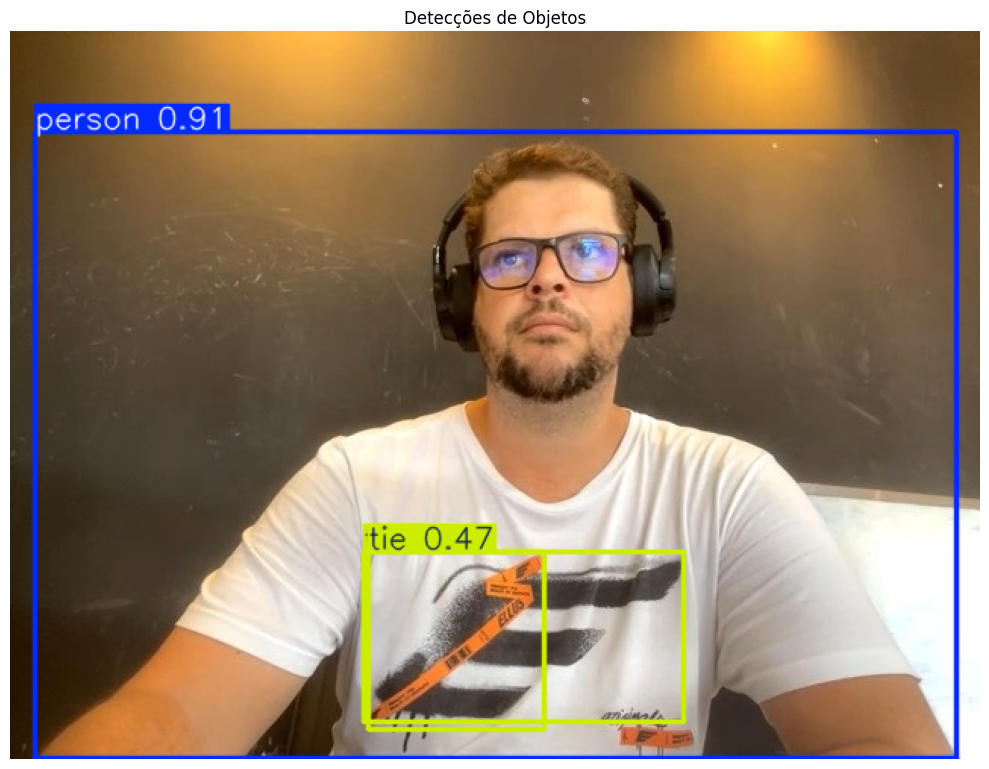


Detecções:
Detectado: person (Confiança: 0.91)
Detectado: tie (Confiança: 0.47)
Detectado: tie (Confiança: 0.39)

image 1/1 /content/yolo_results/webcam_capture.jpg: 480x640 1 person, 1 cell phone, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


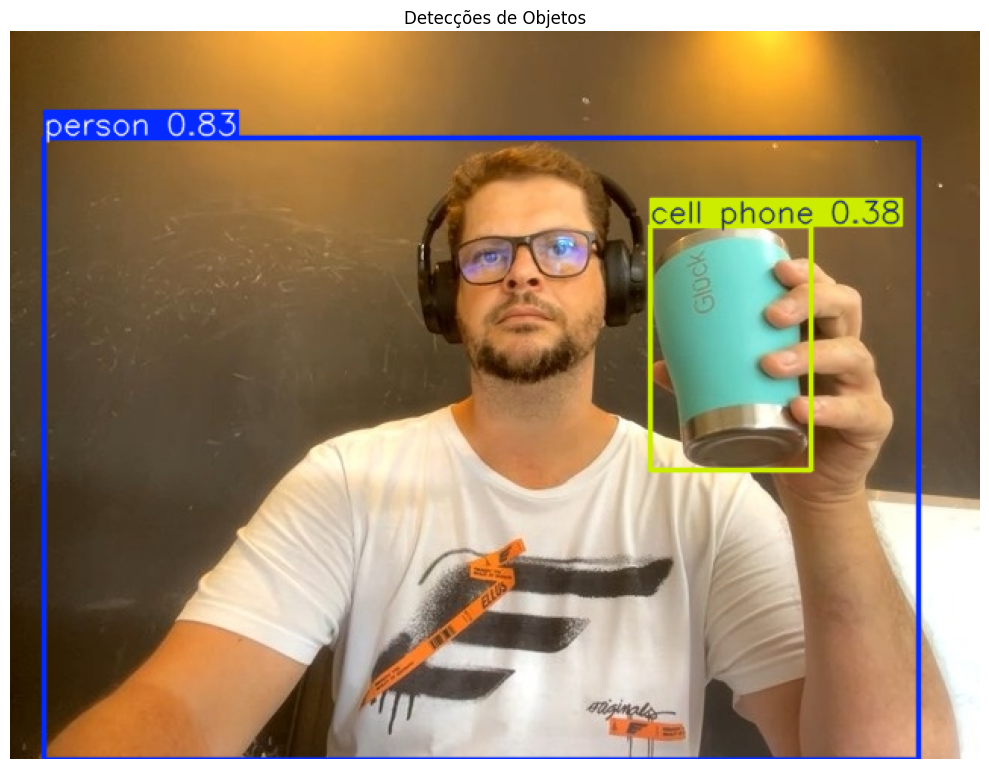


Detecções:
Detectado: person (Confiança: 0.83)
Detectado: cell phone (Confiança: 0.38)


In [6]:
# Carregar modelo COCO
model = YOLO('yolov8n.pt')

# HTML e JavaScript para captura de webcam
webcam_html = """
<div id="camera-container" style="width:640px; height:auto;">
    <video id="video" width="640" height="480" autoplay></video>
    <canvas id="canvas" width="640" height="480" style="display:none;"></canvas>
    <button id="capture-btn" style="margin-top:10px;">Capturar Foto</button>
    <button id="stop-btn" style="margin-top:10px;">Parar Captura</button>
    <div id="result-container" style="margin-top:10px;">
        <h3>Imagem Capturada:</h3>
        <img id="captured-image" style="display:none; max-width:100%;">
        <h3>Detecções:</h3>
        <img id="detection-image" style="display:none; max-width:100%;">
        <div id="detection-text"></div>
    </div>
</div>

<script>
    const video = document.getElementById('video');
    const canvas = document.getElementById('canvas');
    const captureBtn = document.getElementById('capture-btn');
    const stopBtn = document.getElementById('stop-btn');
    const capturedImage = document.getElementById('captured-image');
    const detectionImage = document.getElementById('detection-image');
    const detectionText = document.getElementById('detection-text');

    let stream = null;

    // Solicitar acesso à webcam
    navigator.mediaDevices.getUserMedia({ video: true })
        .then(function(s) {
            stream = s;
            video.srcObject = stream;
        })
        .catch(function(err) {
            console.log("Erro ao acessar webcam: " + err);
        });

    // Capturar foto
    captureBtn.addEventListener('click', function() {
        // Limpar resultados anteriores
        capturedImage.style.display = 'none';
        detectionImage.style.display = 'none';
        detectionText.innerHTML = '';

        // Capturar frame
        canvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
        const imageDataUrl = canvas.toDataURL('image/jpeg');

        // Mostrar imagem capturada
        capturedImage.src = imageDataUrl;
        capturedImage.style.display = 'block';

        // Enviar imagem para processamento (Colab)
        google.colab.output.setIframeHeight(0, true, {maxHeight: 2000});
        google.colab.kernel.invokeFunction('detecao_objetos', [imageDataUrl], {});
    });

    // Parar captura
    stopBtn.addEventListener('click', function() {
        if (stream) {
            stream.getTracks().forEach(track => track.stop());
            video.srcObject = null;
        }
    });
</script>
"""

def process_webcam_image(base64_image):
    try:
        # Remover prefixo base64 se existir
        if ',' in base64_image:
            base64_image = base64_image.split(',')[1]

        # Decodificar imagem
        image_bytes = base64.b64decode(base64_image)
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        # Criar diretório para resultados se não existir
        os.makedirs('/content/yolo_results', exist_ok=True)

        # Caminhos para salvar imagens
        capture_path = '/content/yolo_results/webcam_capture.jpg'
        detection_path = '/content/yolo_results/detection_result.jpg'

        # Salvar imagem capturada
        cv2.imwrite(capture_path, image)

        # Processar com YOLO
        results = model(capture_path, conf=0.25)

        # Plotar resultados e salvar
        plot_results = results[0].plot()
        cv2.imwrite(detection_path, plot_results)

        # Preparar texto de detecções
        detection_info = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                class_name = result.names[box.cls[0].item()]
                confidence = box.conf[0].item()
                detection_info.append(f"Detectado: {class_name} (Confiança: {confidence:.2f})")

        # Exibir imagem com detecções usando matplotlib
        plt.figure(figsize=(10,8))
        detection_image = cv2.cvtColor(plot_results, cv2.COLOR_BGR2RGB)
        plt.imshow(detection_image)
        plt.axis('off')
        plt.title('Detecções de Objetos')
        plt.tight_layout()
        plt.show()

        # Imprimir detecções
        print("\nDetecções:")
        for info in detection_info:
            print(info)

    except Exception as e:
        print(f"Erro no processamento: {e}")
        import traceback
        traceback.print_exc()

# Exibir interface da webcam
display(HTML(webcam_html))

# Registrar callback para processamento
from google.colab import output
output.register_callback('detecao_objetos', process_webcam_image)


## Configuração do Sistema de Streaming em Tempo Real

### Funções de Conversão e Processamento de Imagem

Este código implementa as funções essenciais para estabelecer um streaming de vídeo em tempo real com processamento de imagem no Google Colab. O sistema é composto por três componentes principais:

1. **Conversão JavaScript para OpenCV (`js_to_image`)**
   - Converte dados da webcam em formato base64 para imagem OpenCV
   - Permite processamento em tempo real dos frames capturados
   - Mantém compatibilidade entre JavaScript e Python

2. **Conversão de Bounding Boxes (`bbox_to_bytes`)**
   - Transforma as anotações de detecção em formato adequado para streaming
   - Gerencia canais RGBA para sobreposição transparente
   - Prepara dados para visualização em tempo real

3. **Interface de Streaming (`video_stream`)**
   - Implementa interface JavaScript para captura de vídeo
   - Configurações:
     - Resolução: 640x480 pixels
     - Formato: JPEG (qualidade 0.8)
     - Interface: HTML5 Video API

### Recursos Implementados
- Captura contínua de frames da webcam
- Interface interativa com controles de início/parada
- Sistema de eventos para processamento assíncrono
- Gerenciamento automático de recursos da webcam
- Compatibilidade com ambiente Colab

### Estrutura do DOM
- Container de vídeo com borda
- Elementos de status e controle
- Canvas para processamento de frames
- Overlay para exibição de detecções

### Observações Técnicas
- Utiliza APIs modernas de navegador (MediaDevices)
- Sistema assíncrono para melhor performance
- Gerenciamento automático de memória
- Compatível com diferentes resoluções de webcam

### Requisitos
- Navegador moderno com suporte a WebRTC
- Permissões de acesso à webcam
- JavaScript habilitado

In [10]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Detecção de Objetos em Tempo Real com YOLOv8

### Loop Principal de Detecção em Streaming

Este código implementa o loop principal de detecção de objetos em tempo real, processando o stream da webcam frame por frame. O sistema realiza detecção contínua usando o modelo YOLOv8 pré-treinado com dataset COCO.

### Processo de Detecção

1. **Inicialização do Stream**
   - Ativa stream da webcam
   - Prepara overlay transparente para anotações
   - Inicializa variáveis de controle

2. **Processamento de Frames**
   - Loop contínuo para processamento frame a frame
   - Sistema de captura via JavaScript
   - Conversão de formatos para processamento
   - Preparação de canvas transparente para anotações

3. **Inferência YOLOv8**
   - Threshold de confiança: 0.25 (25%)
   - Processamento em batch único
   - Extração de:
     - Coordenadas das boxes (x1, y1, x2, y2)
     - Níveis de confiança
     - Classes detectadas

4. **Visualização em Tempo Real**
   - Desenho de bounding boxes em verde
   - Anotações com:
     - Nome da classe detectada
     - Nível de confiança
   - Overlay transparente sobre o stream

### Parâmetros Técnicos

#### Configurações de Imagem
- **Resolução**: 480x640 pixels
- **Formato de Cor**: RGBA para overlay
- **Espessura das Boxes**: 2 pixels
- **Cor das Anotações**: Verde (0, 255, 0, 255)
- **Fonte**: HERSHEY_SIMPLEX, escala 0.5

#### Processamento
- **Modelo**: YOLOv8 pré-treinado
- **Confiança Mínima**: 0.25
- **Formato de Entrada**: BGR (OpenCV)
- **Formato de Saída**: Base64 para streaming

### Fluxo de Dados
1. **Captura**
   - Frame da Webcam (base64)
   - Conversão para OpenCV (BGR)

2. **Processamento**
   - Inferência YOLOv8
   - Geração de Overlay
   - Conversão para Stream

3. **Exibição**
   - Renderização em tempo real
   - Sobreposição de anotações
   - Atualização contínua

### Observações
- **Operação**: Sistema opera em loop contínuo até interrupção manual
- **Performance**: Processamento frame-a-frame em tempo real
- **Memória**: Gerenciamento automático de recursos
- **Visualização**: Overlay transparente para melhor experiência visual
- **Interrupção**: Sistema pode ser parado a qualquer momento


In [11]:
# start streaming video from webcam
video_stream()
label_html = 'Capturing...'
bbox = ''  # bounding-box overlay vazio (base64), para iniciar
count = 0

while True:
    # Busca um frame do JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        # Se não há mais frames (ou o usuário parou)
        break

    # Converte o frame de base64 -> OpenCV (BGR)
    frame = js_to_image(js_reply["img"])  # (altura=480, largura=640)

    # Cria um overlay RGBA transparente (480x640) para desenhar as bboxes
    bbox_array = np.zeros((480, 640, 4), dtype=np.uint8)

    # ==== [YOLOv8 INFERÊNCIA] ====
    # Faz a inferência no frame usando YOLOv8
    results = model.predict(frame, conf=0.25, verbose=False)

    # Normalmente results[0] é o que queremos (caso batch=1)
    # Extraímos boxes, confs, classes
    boxes_xyxy = results[0].boxes.xyxy.cpu().numpy()  # [N, 4] -> (x1,y1,x2,y2)
    confs      = results[0].boxes.conf.cpu().numpy()  # [N]
    classes    = results[0].boxes.cls.cpu().numpy()   # [N]

    # Para cada detecção, desenhamos as caixas
    for i in range(len(boxes_xyxy)):
        x1, y1, x2, y2 = boxes_xyxy[i]
        conf = confs[i]
        cls_idx = int(classes[i])
        label = model.names[cls_idx]  # Nome da classe

        # Convertemos coords para int
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))

        # Desenha retângulo (em verde, por exemplo)
        color = (0, 255, 0, 255)  # RGBA (com alpha=255)
        cv2.rectangle(bbox_array, (x1, y1), (x2, y2), color, 2)

        # Texto de identificação
        text = f"{label} {conf:.2f}"
        cv2.putText(bbox_array, text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Ajusta canal alpha: pontos onde (R,G,B) > 0 tornam-se alpha=255
    bbox_array[:,:,3] = (bbox_array.max(axis=2) > 0).astype(np.uint8) * 255

    # Converte overlay para base64
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Atualiza 'bbox' para que o próximo frame exiba este overlay
    bbox = bbox_bytes


<IPython.core.display.Javascript object>